# Classifição de Doenças Em Vaca: ceratoconjuntivite infecciosa bovina, doencas de casco bovina, febre aftosa, doenca grumosa e vacas saudaveis.

## Objectivo

O objectivo é de criar um modelo com a deep learning que pode ser usado para facilitar o trabalho de camponês a detectar 4 diversas doenças forma mais eficiente.

Isto requer que o modelo atinga uma acúracia de pelos 85% ou mais e tenha uma boa precisão.

### 1. Importar as bibliotecas necessarias

In [1]:
# importaçao das Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import warnings
warnings.filterwarnings('ignore')
import pathlib

from zipfile import ZipFile
import PIL
import shutil

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout,Dense, Flatten, Activation, BatchNormalization, Conv2D, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras.applications import MobileNet
%matplotlib inline

### 2. Carregar as imagens de treino e o dataset de validacao
#### i. Pegar o directorio do dataset de imagens

In [2]:
#directorio de treino e teste
train_dataset_path=pathlib.Path('dataset/train')
validation_dataset_path=pathlib.Path('dataset/test')

#### ii. Carregar as imagens do datase e aplicaco aumentacao

In [3]:
BATCH_SIZE=32
IMG_HEIGHT=150
IMG_WIDTH=150

In [4]:
# aumentacao...imagens e classes que pertencem
ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255,
                                   fill_mode='nearest')
                                   
train_generator = train_datagen.flow_from_directory(
    train_dataset_path, 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


Found 1668 images belonging to 5 classes.


In [5]:
# Carregar dataset de validacao
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)


Found 371 images belonging to 5 classes.


In [41]:
train_steps = np.ceil(train_generator.samples // train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
print(train_steps)
print(val_steps)

52.0
12.0


### ii.1. Divivisão dos dados de teste

In [42]:
# Pasta contendo as imagens
pasta_imagens=pathlib.Path('dataset/train/febre aftosa/')

In [43]:
# Listar todos os arquivos na pasta
arquivos = os.listdir(pasta_imagens)

# Listas para armazenar as imagens e rótulos
imagens = []

print("Total de arquivos nesse directorio ",len(arquivos))
print("Total de arquivos nesse directorio para teste ",round(len(arquivos)*0.2))

Total de arquivos nesse directorio  308
Total de arquivos nesse directorio para teste  62


#### iii. Pegar as labels de mapeamento

In [44]:
labels={value:key for key, value in train_generator.class_indices.items()}

print("Mapeamento das Labels para classes presente no dataset de treino e validacao\n")
for key, value in labels.items():
    print(f"{key}:{value}")

Mapeamento das Labels para classes presente no dataset de treino e validacao

0:ceratoconjuntivite infecciosa bovina
1:doencas de casco bovina
2:febre aftosa
3:healthycows
4:lumpycows


### 3. Traçar Grafico Amostra de Imagens de Treino

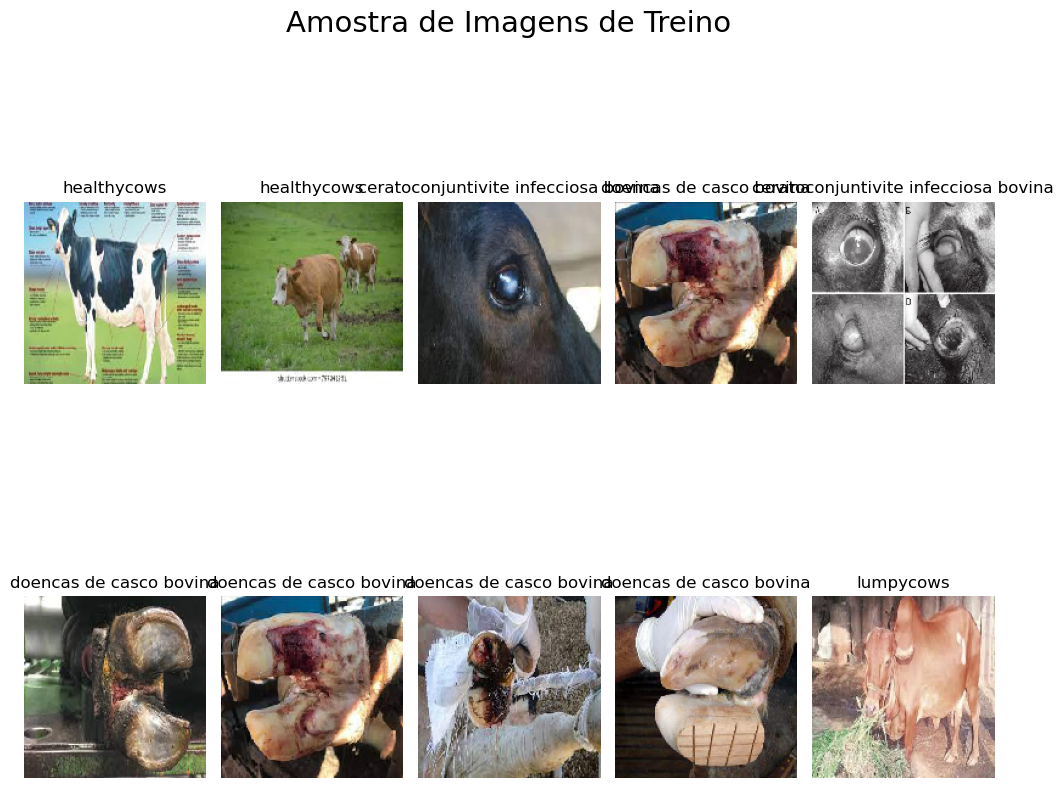

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 10))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx+=1

plt.tight_layout()
plt.suptitle("Amostra de Imagens de Treino",fontsize=21)
plt.savefig("Amostra-de-Imagens-de-Treino.png")
plt.show()


### 4. Treinar o Modelo

#### i. Criar o modelo

In [46]:
def create_model():
    base_model = MobileNet(weights='mobilenet_1_0_224_tf_no_top.h5', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels), activation='softmax'))
    
    return model

In [47]:
cnn_model=create_model()

In [48]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_150 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 3,492,549
Trainable params: 263,685
Non-

In [49]:
#representacao grafica das camadas do modelo
import tensorflow as tf

tf.keras.utils.plot_model(
  cnn_model, to_file='img_model.png', show_dtype=True, dpi=100, show_shapes=True, expand_nested=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### ii. Definindo callbacks

In [50]:
#reduzir a taxa de aprendizagem com Plateau.
#Reduzir a taxa de aprendizagem quando as metricas param de melhorar.
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5) 

#### iii. Definindo o optmizador

In [51]:
optimizer=Adam(learning_rate=0.001)

#### iv. Compilar o modelo

In [52]:
cnn_model.compile(optimizer=optimizer,loss=CategoricalCrossentropy(),metrics=['accuracy'])

#### v. Treinar o modelo

In [53]:
history = cnn_model.fit(
    train_generator, 
    epochs=15,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    validation_data=validation_generator,
    verbose=1, 
    callbacks=[reduce_lr])


Epoch 1/15
52/52 [==============================] - 73s 1s/step - loss: 0.7418 - accuracy: 0.7567 - val_loss: 0.7341 - val_accuracy: 0.7008 - lr: 0.0010
Epoch 2/15
52/52 [==============================] - 48s 927ms/step - loss: 0.2535 - accuracy: 0.9016 - val_loss: 0.5230 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 3/15
52/52 [==============================] - 40s 764ms/step - loss: 0.1883 - accuracy: 0.9279 - val_loss: 0.5468 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 4/15
52/52 [==============================] - 42s 803ms/step - loss: 0.1372 - accuracy: 0.9474 - val_loss: 0.5232 - val_accuracy: 0.8329 - lr: 0.0010
Epoch 5/15
52/52 [==============================] - 41s 785ms/step - loss: 0.1055 - accuracy: 0.9554 - val_loss: 0.4959 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 6/15
52/52 [==============================] - 40s 775ms/step - loss: 0.0993 - accuracy: 0.9639 - val_loss: 0.5116 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 7/15
52/52 [==============================] - 40s 775ms/step 

### 5. Traçar Gráfico das Métricas do Modelo

#### i. Traçar o gráfico da acurácia, perdas e taxa de aprendizagem no treino e validacao

In [54]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']


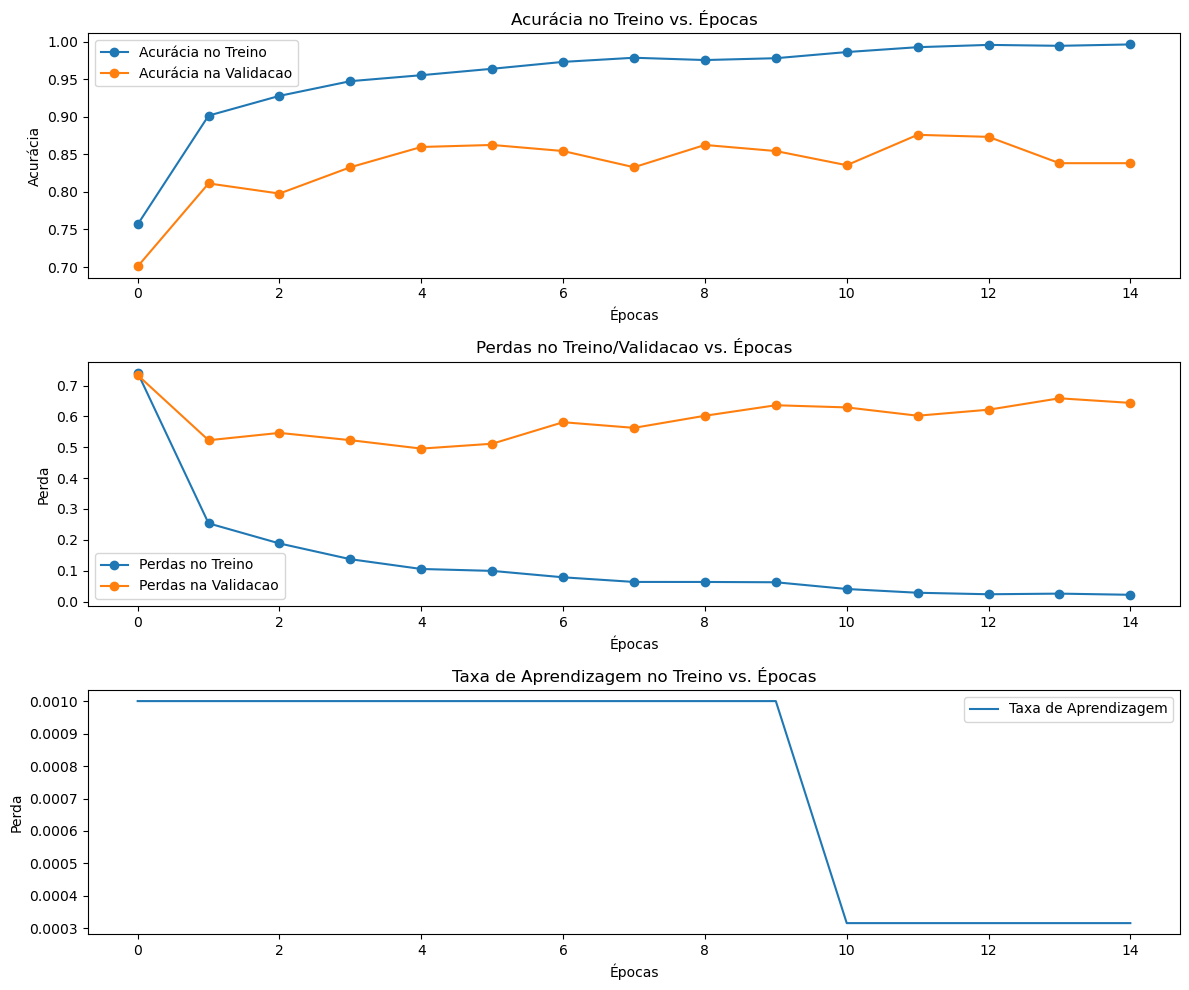

In [55]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))
ax[0].set_title("Acurácia no Treino vs. Épocas")
ax[0].plot(train_accuracy, 'o-', label='Acurácia no Treino')
ax[0].plot(val_accuracy, 'o-', label='Acurácia na Validacao')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Acurácia')
ax[0].legend(loc='best')


ax[1].set_title("Perdas no Treino/Validacao vs. Épocas")
ax[1].plot(train_loss, 'o-', label='Perdas no Treino')
ax[1].plot(val_loss, 'o-', label='Perdas na Validacao')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Perda')
ax[1].legend(loc='best')


ax[2].set_title("Taxa de Aprendizagem no Treino vs. Épocas")
ax[2].plot(learning_rate, label='Taxa de Aprendizagem')
ax[2].set_xlabel('Épocas')
ax[2].set_ylabel('Perda')
ax[2].legend(loc='best')

plt.tight_layout()
plt.savefig("gráfico-da-acurácia-perdas-e-taxa-de-aprendizagem-no-treino-e-validacao-15-epocas-mobilenet.png")
plt.show()

In [56]:
#salvar o modelo para testes"
cnn_model.save("cow-diseases-15-epochs-mobilenet.h5")

### 6. Testar o Modelo no Dataset do Teste

In [57]:
#testar o modelo no dataset de validacao, o teste
test_dataset=pathlib.Path('dataset/Test')

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='categorical'
)


Found 371 images belonging to 5 classes.


### 7. Modelo de Previsao no Dataset de Test

In [59]:
predictions=cnn_model.predict(test_generator)

12/12 [==============================] - 7s 484ms/step


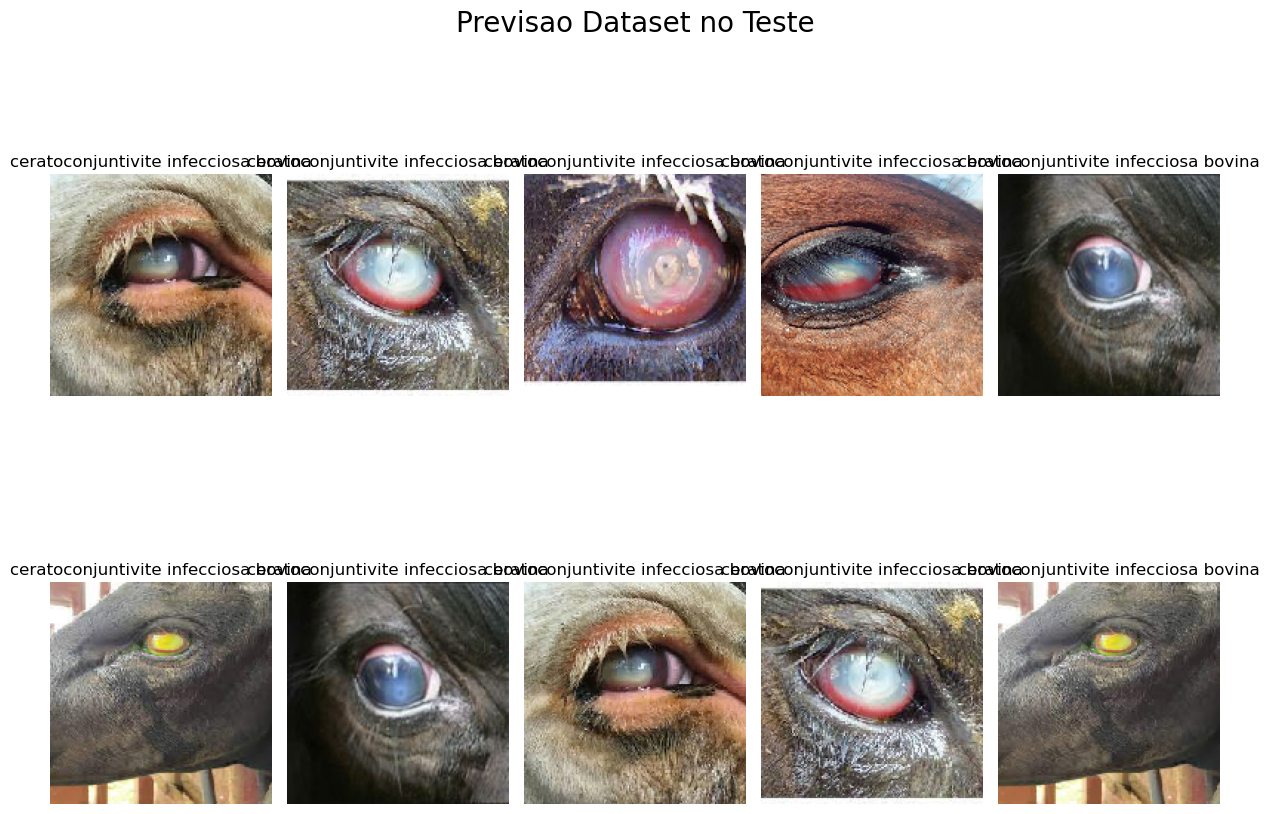

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Previsao Dataset no Teste",fontsize=20)
plt.savefig("Previsao-Dataset-no-Teste-15-epocas-mobilenet.png")
plt.show()


In [60]:
test_loss,test_accuracy=cnn_model.evaluate(test_generator,batch_size=BATCH_SIZE)

12/12 [==============================] - 6s 475ms/step - loss: 0.6441 - accuracy: 0.8383


In [61]:
print(f"Perdas no teste: {test_loss}")
print(f"Acurária no teste: {test_accuracy}")

Perdas no teste: 0.6441006064414978
Acurária no teste: 0.8382749557495117


### 8. Traçando Gráfico das Metricas de Classificacao

#### i. Matriz de Confusao

In [62]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

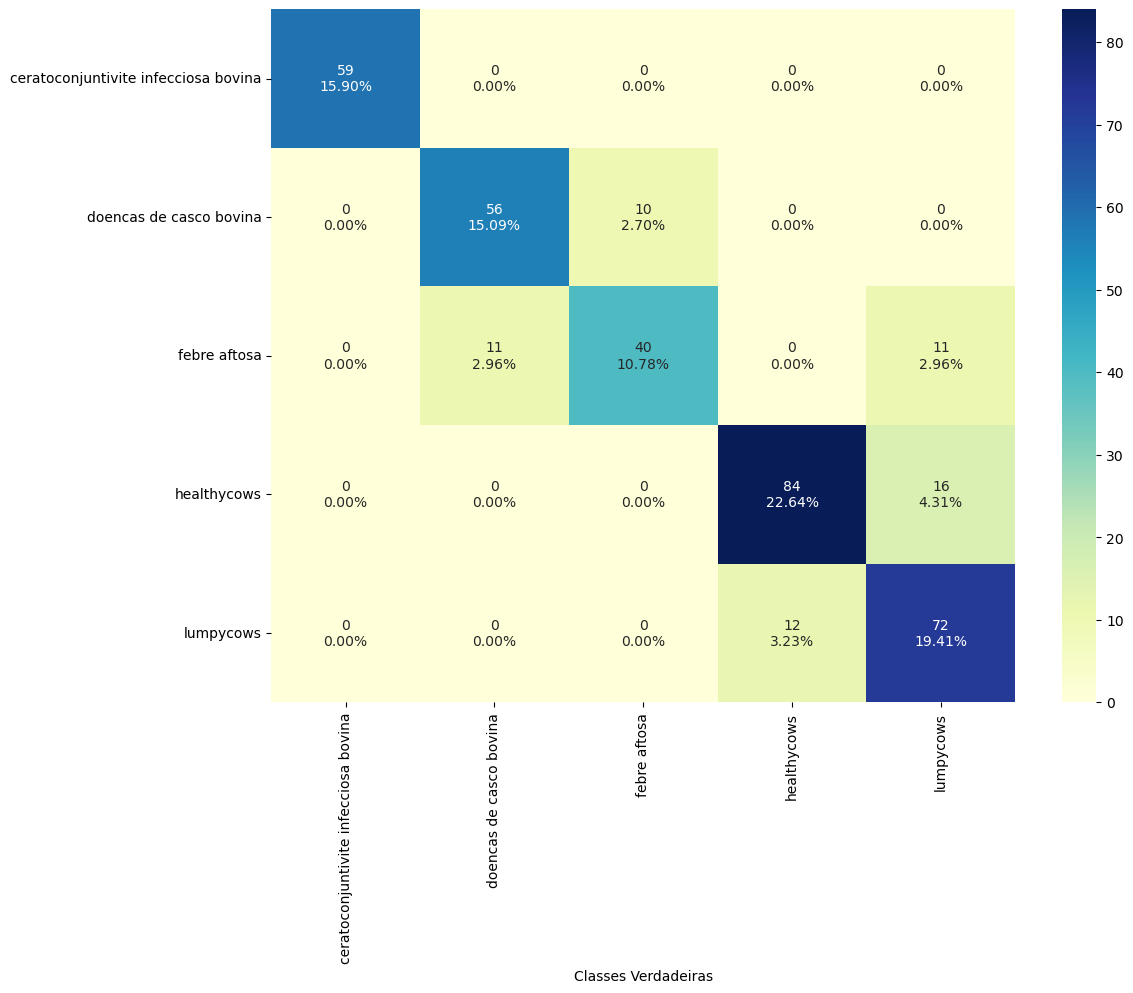

In [63]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts=["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages=["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels=[f"{v1}\n{v2}" for v1,v2 in zip(group_counts,group_percentages)]
box_labels=np.asarray(box_labels).reshape(5,5)

plt.figure(figsize=(12,9))
sns.heatmap(cf_mtx,xticklabels=labels.values(), yticklabels=labels.values(), cmap='YlGnBu',fmt="",annot=box_labels)
plt.xlabel("Classes Previstas")
plt.xlabel("Classes Verdadeiras")
plt.savefig("matrix-de-confusao-15-epocas-mobilenet.png")
plt.show()

### Calcular a Curva ROC

In [64]:
#carregar o modelo treinado
#Aqui a melhor epoca sera usada.
loaded_model = keras.keras.models.load_model('cow-diseases-15-epochs-mobilenet.h5')
loaded_model.compile(loss=CategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
#predictions=cnn_model.predict(test_generator)

Valor de ROC AUC:  0.8984003864776178


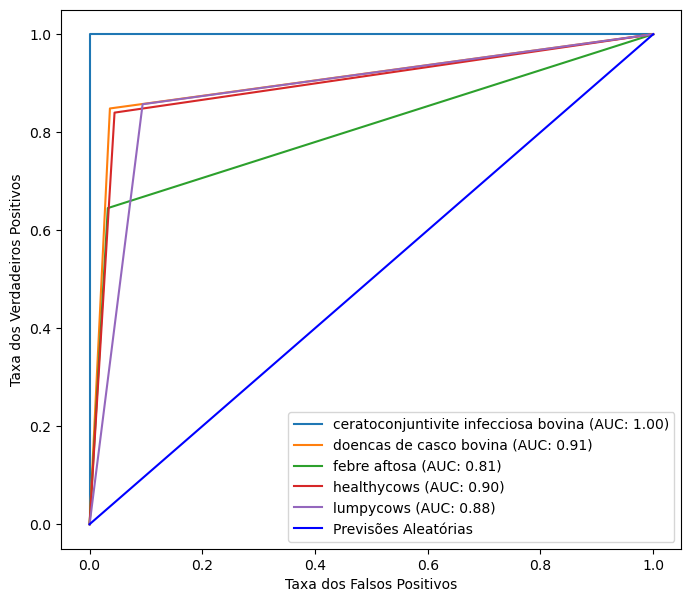

In [65]:
target = labels.values()

# definir o tamanho da figura
fig, c_ax = plt.subplots(1, 1, figsize=(8, 7))

# funcao para calcular a curva roc para multiclasses
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, label='%s (AUC: %0.2f)' % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label='Previsões Aleatórias')
    return roc_auc_score(y_test, y_pred, average=average)


print("Valor de ROC AUC: ", multiclass_roc_auc_score(y_true, y_pred))
c_ax.legend()
c_ax.set_xlabel('Taxa dos Falsos Positivos')
c_ax.set_ylabel('Taxa dos Verdadeiros Positivos')

plt.savefig("curva-roc-multiclass-15-epocas-mobilenet.png")
plt.show()

In [66]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                                      precision    recall  f1-score   support

ceratoconjuntivite infecciosa bovina       1.00      1.00      1.00        59
             doencas de casco bovina       0.84      0.85      0.84        66
                        febre aftosa       0.80      0.65      0.71        62
                         healthycows       0.88      0.84      0.86       100
                           lumpycows       0.73      0.86      0.79        84

                            accuracy                           0.84       371
                           macro avg       0.85      0.84      0.84       371
                        weighted avg       0.84      0.84      0.84       371



### 9. Classificacoes Erradas

In [69]:
# vamos ver se o modelo classificou de forma errada
errors = (y_true-y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]


In [70]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]


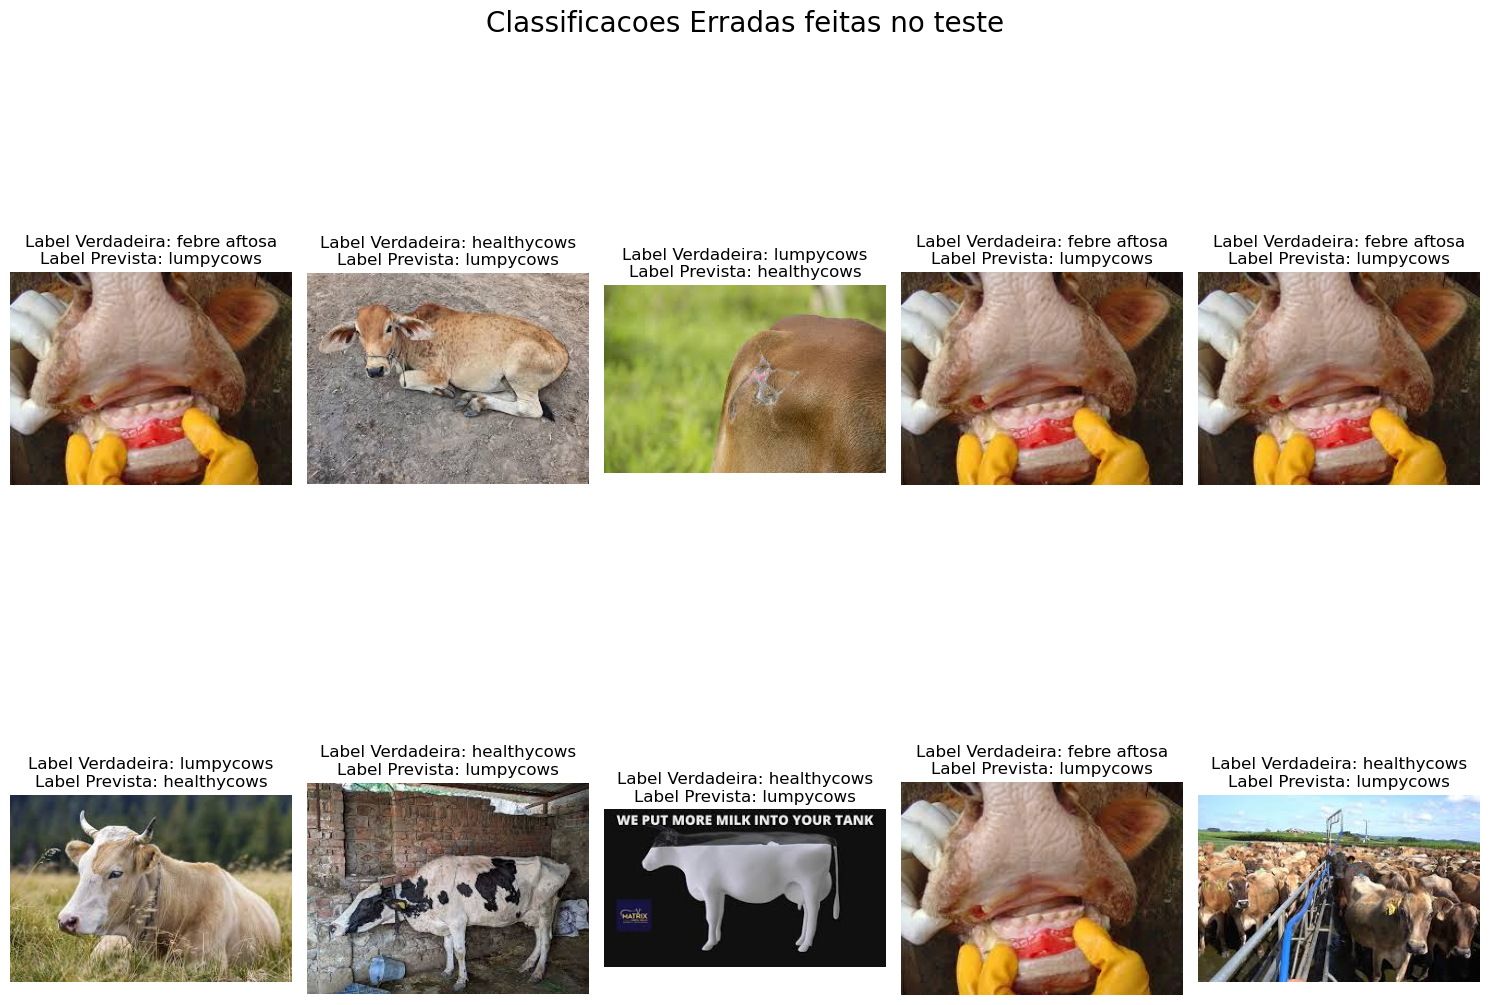

In [72]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 13))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]

        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]

        ax[i, j].set_title(f"Label Verdadeira: {true_label}\nLabel Prevista: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(img)
        ax[i,j].axis("off")

plt.tight_layout()
plt.suptitle("Classificacoes Erradas feitas no teste", fontsize=20)
plt.savefig("Classificacoes-Erradas-feitas-no-teste-15-epocas-mobilenet.png")
plt.show()

####